In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import pandas as pd
import os, sys
from scipy import interpolate
import cartopy.crs as ccrs
import matplotlib.colors as colors
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.collections import LineCollection
from matplotlib import cm
from datetime import datetime
import pickle

In [2]:
sys.path.append(os.path.abspath("/work/bb1018/b380873/tropic_vis/traj/"))
from traj_psd_obs import traj_psd

In [3]:
# Helper function to - you guessed it - make sexy axes for generic values
def sexy_axes(ax,fs):
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

In [4]:
# Helper function to make sexy axes for pressure levels
def sexy_axes2(ax, fs, ylab):
    ax.set_ylim([50,800])
    ax.set_yscale('log')
    ax.set_yticks([800,500,300,100])
    ax.set_yticklabels(['800','500','300','100'])
    if ylab == True:
        ax.set_ylabel('Pressure [hPa]',fontsize=fs)
    ax.invert_yaxis()
    
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.yaxis.set_ticks_position('left') 
    ax.tick_params('both',labelsize=fs,rotation=45)

In [5]:
# More helper functions
# Pulling this from the following stackoverflow
# https://stackoverflow.com/questions/30030328/correct-placement-of-colorbar-relative-to-geo-axes-cartopy
def resize_colorbar(event):
    plt.draw()
    posn = ax.get_position()
    # left, bottom, width, height
    cbar_ax.set_position([posn.x0 + posn.width + 0.01, posn.y0 - 0.018,
                          0.025, posn.height + 0.03])
    cbar_ax.tick_params(labelsize=fs)

# Define a function to convert radians to degrees.
def rad2deg(x):
    return x*180/pi

# Define a function to prepend zeros to a file name
def file_prefix(j):
    if len(str(j)) == 1:
       return '00'
    elif len(str(j)) == 2:
       return '0'
    elif len(str(j)) == 3:
       return ''
    else:
       return 'Inappropriate length of input to file_prefix'

# Figure 1: Domain topography + flight track and trajectory sample

In [5]:
# Domain topography map
file = '/work/bb1018/b380459/TROPIC/extpar/extpar_icon-grid_tropic_55e170e5s40n_R2500m_bitmap.nc'
dset = xr.open_dataset(str(file))
x, y = dset['lon'].values, dset['lat'].values  # shape = (9648304,)

# Flight 7 track
basedir = '/work/bb1018/b380873/tropic_vis/'
scfi = basedir + 'obs/stratoclim2017.geophysika.0808_1.master.ci_eval.nc'
sc_data = xr.open_dataset(scfi)
lat_sc = sc_data['BEST:LAT'].values
lon_sc = sc_data['BEST:LON'].values
t_sc = sc_data['time'].values
i_sc = np.argwhere((~np.isnan(lat_sc)) & (~np.isnan(lon_sc)) & (lat_sc > 0) & (lon_sc > 0))

/sw/rhel6-x64/conda/anaconda3-bleeding_edge/lib/python3.6/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in greater
  del sys.path[0]


In [6]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """Truncate a coloramp by specifying the start and endpoint."""
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n}.{a:.2f},{b:.2f})'.format(n=cmap.name,a=minval,b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return(new_cmap)

In [7]:
# Read in a full 51-hour long trajectory file. Initialize empty arrays for altitude, latitude, longitude.
basedir = '/scratch/b/b380873/traj_full51h_fast/'
pi = 3.141592653589793238
os.environ["CARTOPY_USER_BACKGROUNDS"] = "/pf/b/b380873/conda-envs/ncplot/lib/python3.7/site-packages/cartopy/data/raster/natural_earth"

# Below the file is just a sample one.
fi_name = basedir + 'traj_tst00000450_p011.nc'
timesteps = 7651
numtraj = xr.open_dataset(fi_name).dims['id']

traj_alt = np.zeros((timesteps,numtraj))
traj_lat = np.zeros((timesteps,numtraj))
traj_lon = np.zeros((timesteps,numtraj))

In [8]:
# Read in the altitude, longitude, latitude values
fi = xr.open_dataset(fi_name)
alt = fi.alt.values
lon = fi.lon.values
lat = fi.lat.values
t = fi.t.values
rtime = fi.rtime.values

# Find indices where the matrix != 0.
xs, ys = np.where(alt != 0)
# Extract the square with extreme limits.
# In limited testing, this seems always to generate [=] (88,5308)
alt = alt[:max(xs)+1,:max(ys)+1]
lon = lon[:max(xs)+1,:max(ys)+1]
lat = lat[:max(xs)+1,:max(ys)+1]
rtime = rtime[:max(xs)+1]

In [9]:
# Store the trimmed matrices.
temp1 = alt/1000.
temp2 = rad2deg(lat)
temp3 = rad2deg(lon)

# Mask the negative altitudes and fill values (-999.) for latitudes and longitudes.
traj_alt = np.where((temp1 > 0), temp1, np.nan)
traj_lat = np.where((temp2 >= -90.), temp2, np.nan)
traj_lon = np.where((temp3 >= -180.), temp3, np.nan)

<xarray.DataArray 'topography_c' ()>
array(8444.875)


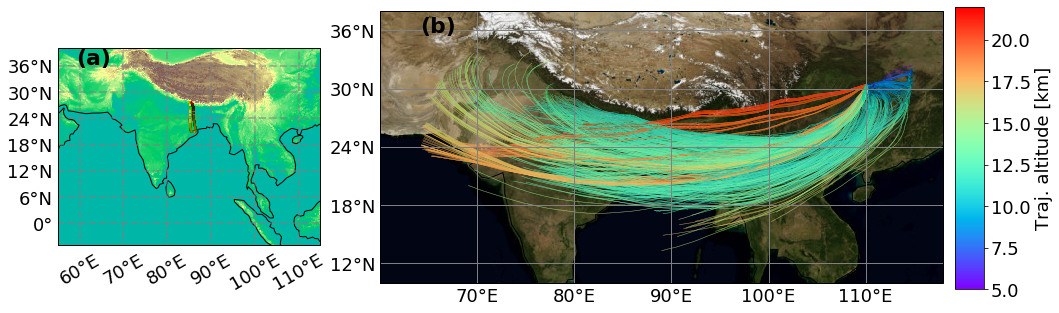

In [14]:
fs = 18
fig = plt.figure(figsize=(16,5))
gs = fig.add_gridspec(1,3)
ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())

cmap = truncate_colormap(plt.get_cmap('terrain'), 0.2, 1.)
ax0.tricontourf(x, y, dset['topography_c'], cmap=cmap, levels=np.arange(-100,8500,10))
print(dset['topography_c'].max())
ax0.coastlines()
ax0.set_extent([55, 115, -5, 40],crs=ccrs.PlateCarree())
ax0.text(0.07,0.92,'(a)',weight='bold',fontsize=fs+4,transform=ax0.transAxes)

gl = ax0.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': fs, 'rotation': 30}
gl.ylabel_style = {'size': fs}

# Pulling from https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/multicolored_line.html
# Create a set of line segments so that we can color them individually
points = np.array([lon_sc[i_sc[:,0]],lat_sc[i_sc[:,0]]]).T.reshape(-1,1,2)
segments = np.concatenate([points[:-1],points[1:]],axis=1)

# Convert the times from np.datetime64 to float
t_sc1 = t_sc[i_sc[:,0]]
t_sc_f = t_sc1.astype("float")/1000000000.0
t_sc_f = t_sc_f - np.nanmin(t_sc_f)
norm = plt.Normalize(t_sc_f.min(),t_sc_f.max())
lc = LineCollection(segments,cmap=cm.autumn,norm=norm)
lc.set_array(t_sc_f)
lc.set_linewidth(2)
ax0.add_collection(lc)

ax1 = fig.add_subplot(gs[0,1:], projection=ccrs.PlateCarree())
gl = ax1.gridlines(crs=ccrs.PlateCarree(),draw_labels=True,linewidth=1,color='gray')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size':fs}
gl.ylabel_style = {'size':fs}

ax1.set_xlabel(r'Latitude [$^{\circ}$N]',fontsize=fs)
ax1.set_ylabel(r'Longitude [$^{\circ}$E]',fontsize=fs)

ax1.set_extent([60,118,10,38],crs=ccrs.PlateCarree()) # large domain
ax1.coastlines()
ax1.background_img(name='BM',resolution='high')
norm = plt.Normalize(5,22)

# How many trajectories to plot?
n = 700
for i in np.arange(n):
    # Create a set of line segments to color individually. Points in N x 1 x 2 array.
    points = np.array([traj_lon[:,i],traj_lat[:,i]]).T.reshape(-1,1,2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    lc = LineCollection(segments,cmap='rainbow',norm=norm)
    lc.set_array(traj_alt[:,i])
    lc.set_linewidth(0.5)
    line = ax1.add_collection(lc)

sm = plt.cm.ScalarMappable(cmap='rainbow',norm=norm)
sm.set_array([])
ax = plt.gca()
cbar_ax = fig.add_axes([0, 0, 0.1, 0.1])

fig.canvas.mpl_connect('resize_event', resize_colorbar)
c = plt.colorbar(sm,cax=cbar_ax)
c.set_label('Traj. altitude [km]',fontsize=fs)
c.ax.tick_params(labelsize=fs)
resize_colorbar(None)
ax1.text(0.07,0.92,'(b)',weight='bold',fontsize=fs+4,transform=ax1.transAxes)

fig.savefig('output/1-topography-traj.png',bbox_inches='tight')
plt.show()

# Figure 2: Updraft velocity PDF + gravity wave spectrum

In [6]:
# Load the observational w values and evaluate their histogram.
basedir = '/work/bb1018/b380873/tropic_vis/obs/POSIDON/'
posidon_winds = pd.read_csv(basedir + 'posidon_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
posidon_winds = posidon_winds[(posidon_winds['z'] >= 15)]
w_obs = posidon_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_obs1, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('POSIDON campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

basedir = '/work/bb1018/b380873/tropic_vis/obs/ATTREX/'
attrex_winds = pd.read_csv(basedir + 'attrex3_vertical_wind2.dat',sep='\s+')

# Filter out the w values only for z > 15 km
attrex_winds = attrex_winds[(attrex_winds['z'] >= 15)]
w_obs = attrex_winds['w']

# Calculate the normalized / relative frequency of these w values
wgts = np.ones_like(w_obs)/len(w_obs)
h_obs2, bin_edges = np.histogram(w_obs, bins=np.linspace(-3,3,100), weights=wgts) # density=True)
print('ATTREX campaign (mean, std) w: ' + str(np.nanmean(w_obs)) + ' ' + str(np.std(w_obs)))

POSIDON campaign (mean, std) w: 0.08748738843285492 0.5858340614769502
ATTREX campaign (mean, std) w: -0.06651030636098923 0.23498594232830203


In [7]:
# Fixed set of frequencies
n = 8000
freq = np.linspace(0,0.4999,n)

# Number of POSIDON flights (9)
posidon_dates = posidon_winds['date'].unique()

# Calculate the power spectral density of observational temperature and updraft signals.
T_PSD_obs = np.zeros((len(posidon_dates), n))
w_PSD_obs = np.zeros((len(posidon_dates), n))

for j, date in enumerate(posidon_dates):
    subset = posidon_winds[(posidon_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 11176, 10480, 11190, 16964, 16208, 15551, 9612, 15899, 10114
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()
    
    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_obs[j] = f(freq)
    w_PSD_obs[j] = f2(freq)

In [8]:
# Number of ATTREX flights (6)
attrex_dates = attrex_winds['date'].unique()

# Calculate the power spectral density of observational temperature signals.
T_PSD_obs2 = np.zeros((len(attrex_dates), n))
w_PSD_obs2 = np.zeros((len(attrex_dates), n))

for j, date in enumerate(attrex_dates):
    subset = attrex_winds[(attrex_winds['date'] == date)] 
    
    # Generate an instance of Class traj_psd with temp = input T time series
    # The T time series have lengths of 39731, 37179, 32700, 46743, 50830, 36647
    traj_obj = traj_psd(subset['T'].values)
    traj_obj2 = traj_psd(subset['w'].values)
    
    # Calculate the power spectral density
    ff, Pxx, _ = traj_obj.calc_psd()
    ff2, Pxx2, _ = traj_obj2.calc_psd()

    # Interpolate the PSD to a fixed set of frequencies
    f = interpolate.interp1d(ff, Pxx, kind='cubic')
    f2 = interpolate.interp1d(ff2, Pxx2, kind='cubic')
    
    # Append the values to the multidimensional list
    T_PSD_obs2[j] = f(freq)
    w_PSD_obs2[j] = f2(freq)

In [9]:
# Load the trajectory frequencies and power spectral densities
suffix = '_Tfluc2' #''
T_ff_sim = np.load('output/T_PSD_ff_sim_traj' + suffix + '.npy')
T_Pxx_sim = np.load('output/T_PSD_Pxx_sim_traj' + suffix + '.npy')

In [10]:
suffix = '_ICON'
w_ff_sim = np.load('output/w_PSD_ff_sim_traj'  + suffix + '.npy')
w_Pxx_sim = np.load('output/w_PSD_Pxx_sim_traj' + suffix + '.npy')

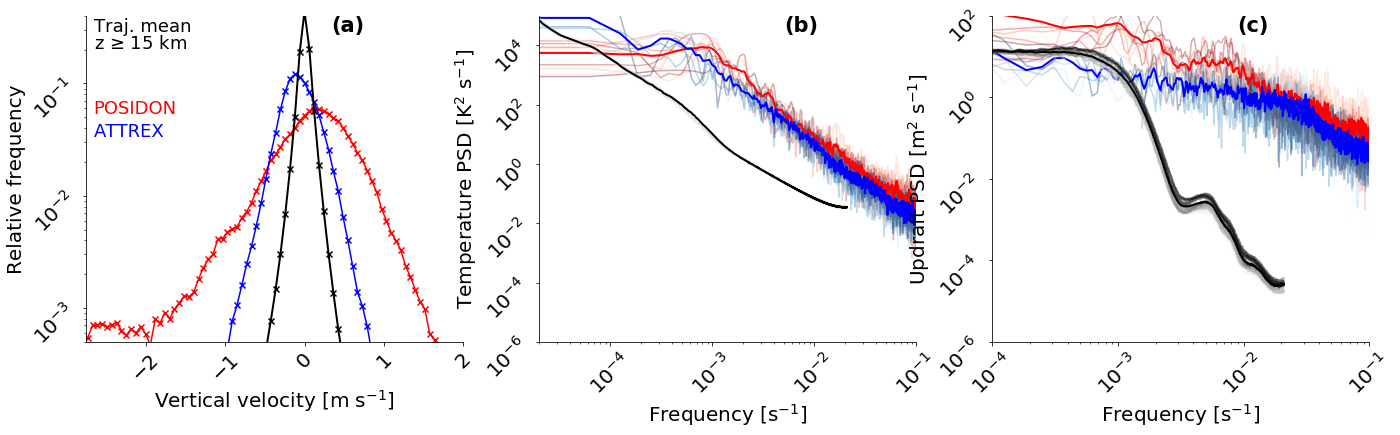

In [11]:
fs = 20
h_sim = np.load('./output/traj_w_histogram_sim.npy')
h_sim2 = np.load('./output/traj_w_histogram_sim-10-15.npy')

fig, ax = plt.subplots(nrows=1,ncols=3,figsize=(23,6))
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_obs1, color='red',label='POSIDON')
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., h_obs2, color='blue',label='ATTREX')
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_obs1, marker='x', color='red')
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., h_obs2, marker='x', color='blue')
ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_sim,axis=0), lw=2, color='k', label='Traj. mean'); # h_sim.T
#ax[0].plot((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_sim2,axis=0), lw=2, color='gray', label='Traj. mean'); # h_sim.T
ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_sim,axis=0), marker='x', color='k')
#ax[0].scatter((bin_edges[1:] + bin_edges[:-1])/2., np.nanmean(h_sim2,axis=0), marker='x', color='gray')
ax[0].text(0.65,0.95,'(a)',weight='bold',fontsize=fs+1,color='k',transform=ax[0].transAxes)
ax[0].text(0.02,0.95,'Traj. mean',fontsize=fs-2,color='k',transform=ax[0].transAxes)
ax[0].text(0.02,0.90,'z $≥$ 15 km',fontsize=fs-2,color='k',transform=ax[0].transAxes)
#ax[0].text(0.02,0.82,r'Traj. mean',fontsize=fs-2,color='grey',transform=ax[0].transAxes)
#ax[0].text(0.02,0.77,'15 km $>$ z $≥$ 10 km',fontsize=fs-2,color='grey',transform=ax[0].transAxes)
ax[0].text(0.02,0.7,'POSIDON',fontsize=fs-2,color='red',transform=ax[0].transAxes)
ax[0].text(0.02,0.63,'ATTREX',fontsize=fs-2,color='blue',transform=ax[0].transAxes)
ax[0].set_yscale('log')
ax[0].spines['right'].set_color('none')
ax[0].set_ylim([0.0005, 0.4])
ax[0].set_xlim([-2.75, 2])
ax[0].set_xlabel(r'Vertical velocity [m s$^{-1}$]',fontsize=fs)
ax[0].set_ylabel('Relative frequency',fontsize=fs)
#ax[0].legend(fontsize=fs-2,frameon=False,loc='left')
sexy_axes(ax[0], fs)

colors = plt.cm.Reds(np.linspace(0,1,len(posidon_dates)))
for j in np.arange(len(posidon_dates)):
    ax[1].plot(freq, T_PSD_obs[j], color=colors[j], alpha=0.35)
    ax[2].plot(freq, w_PSD_obs[j], color=colors[j], alpha=0.35)
colors = plt.cm.Blues(np.linspace(0,1,len(attrex_winds['date'].unique())))   
for j in np.arange(len(attrex_dates)):
    ax[1].plot(freq, T_PSD_obs2[j], color=colors[j], alpha=0.35)
    ax[2].plot(freq, w_PSD_obs2[j], color=colors[j], alpha=0.35)
    
ax[1].plot(freq, np.nanmean(T_PSD_obs,axis=0), color='r', linewidth=2)
ax[1].plot(freq, np.nanmean(T_PSD_obs2,axis=0), color='b', linewidth=2)
ax[2].plot(freq, np.nanmean(w_PSD_obs,axis=0), color='r', linewidth=2)
ax[2].plot(freq, np.nanmean(w_PSD_obs2,axis=0), color='b', linewidth=2)
ax[1].text(0.65,0.95,'(b)',weight='bold',fontsize=fs+1,color='k',transform=ax[1].transAxes)


colors = plt.cm.Greys(np.linspace(0,1,30))
for j in np.arange(10):
    ax[1].plot(T_ff_sim[j], T_Pxx_sim[j], color=colors[j], alpha=0.35)
ax[1].plot(np.nanmean(T_ff_sim,axis=0), np.nanmean(T_Pxx_sim,axis=0), linewidth=2, color='k')
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlim([2*10**-5, 0.1])
ax[1].set_ylim([10**-6, 10**5])
ax[1].set_ylabel(r'Temperature PSD [K$^2$ s$^{-1}$]',fontsize=fs)
ax[1].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[1], fs)

for j in np.arange(30):
    ax[2].plot(w_ff_sim[j], w_Pxx_sim[j], color=colors[j], alpha=0.35)
ax[2].plot(np.nanmean(w_ff_sim,axis=0), np.nanmean(w_Pxx_sim,axis=0), linewidth=2, color='k')
ax[2].text(0.65,0.95,'(c)',weight='bold',fontsize=fs+1,color='k',transform=ax[2].transAxes)
ax[2].set_xscale('log')
ax[2].set_yscale('log')
ax[2].set_xlim([10**-4, 0.1])
ax[2].set_ylim([10**(-6), 10**2])
ax[2].set_ylabel(r'Updraft PSD [m$^2$ s$^{-1}$]',fontsize=fs)
ax[2].set_xlabel(r'Frequency [s$^{-1}$]',fontsize=fs)
sexy_axes(ax[2], fs)
fig.savefig('./output/1-dynamics2_Tfluc2.pdf',bbox_inches='tight')
plt.show()